In [ ]:
# This project aims to investigate the potential correlations between individuals' music tastes and 
# their self-reported mental health, specifically focusing on anxiety levels. By categorizing the continuous 
# 'Anxiety' scores into discrete classes (e.g., 'Low', 'Medium', 'High'), we transform this into a classification 
# problem to explore how different music genres and listening habits might relate to various levels of anxiety.


In [117]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
import numpy as np

In [118]:
# Create an S3 client
s3_client = boto3.client('s3')
bucket = 'ccdaproject'
dataset = 'Music&Mental_health.csv'

In [119]:
# Load the dataset
data = pd.read_csv(f"s3://{bucket}/{dataset}")

In [120]:
# Preprocessing Step 1: Handling Missing Values
# Filling missing values for numerical columns with the median
for col in data.select_dtypes(include='number').columns:
    data[col].fillna(data[col].median(), inplace=True)

# Filling missing values for categorical columns with the mode (most frequent value)
for col in data.select_dtypes(include='object').columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Preprocessing Step 2: Encoding Categorical Variables
# We'll use one-hot encoding for categorical variables that are not ordinal
categorical_cols = data.select_dtypes(include='object').columns
data_encoded = pd.get_dummies(data, columns=categorical_cols.drop(['Timestamp']), drop_first=True)

# The dataset after preprocessing
print(data_encoded.head())

            Timestamp   Age  Hours_per_day    BPM  Anxiety  Depression  \
0  8/27/2022 19:29:02  18.0            3.0  156.0      3.0         0.0   
1  8/27/2022 19:57:31  63.0            1.5  119.0      7.0         2.0   
2  8/27/2022 21:28:18  18.0            4.0  132.0      7.0         7.0   
3  8/27/2022 21:40:40  61.0            2.5   84.0      9.0         7.0   
4  8/27/2022 21:54:47  18.0            4.0  107.0      7.0         2.0   

   Insomnia  OCD  Primary_streaming_service_I do not use a streaming service.  \
0       1.0  0.0                                              False             
1       2.0  1.0                                              False             
2      10.0  2.0                                              False             
3       3.0  3.0                                              False             
4       5.0  9.0                                              False             

   Primary_streaming_service_Other streaming service  ...  \
0      

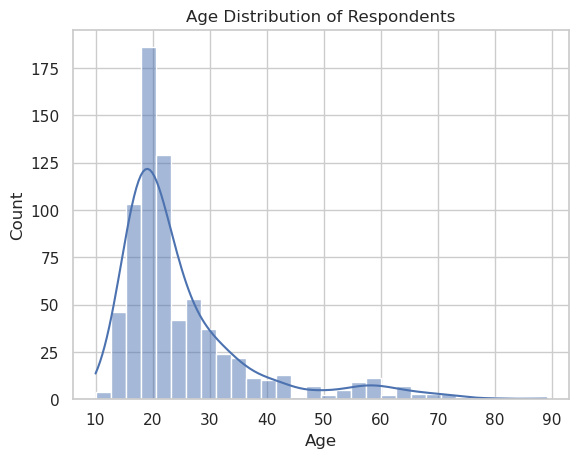

In [121]:
sns.histplot(data['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution of Respondents')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

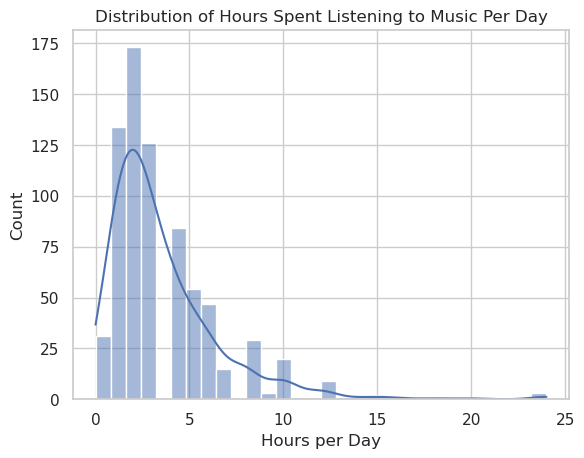

In [122]:
sns.histplot(data['Hours_per_day'].dropna(), bins=30, kde=True)
plt.title('Distribution of Hours Spent Listening to Music Per Day')
plt.xlabel('Hours per Day')
plt.ylabel('Count')
plt.show()

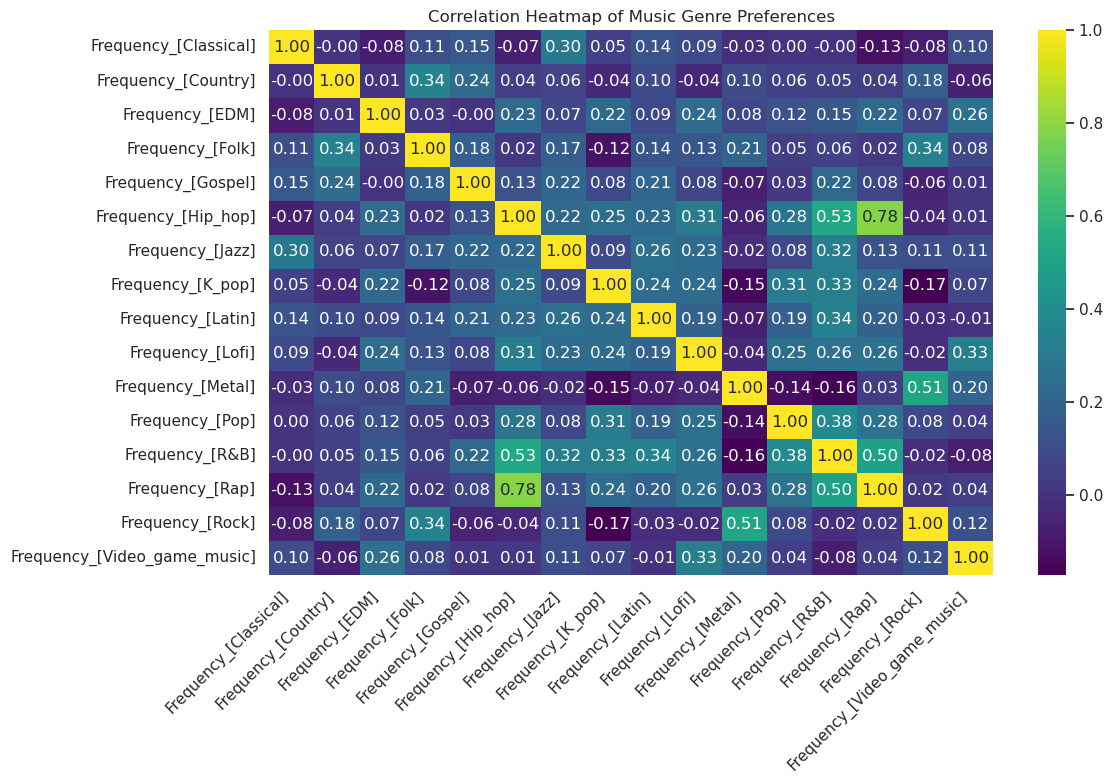

In [123]:
genre_columns = [col for col in data.columns if col.startswith('Frequency_')]
genre_preferences = data[genre_columns].apply(lambda x: x.astype('category').cat.codes)

plt.figure(figsize=(12, 8))
sns.heatmap(genre_preferences.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap of Music Genre Preferences')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

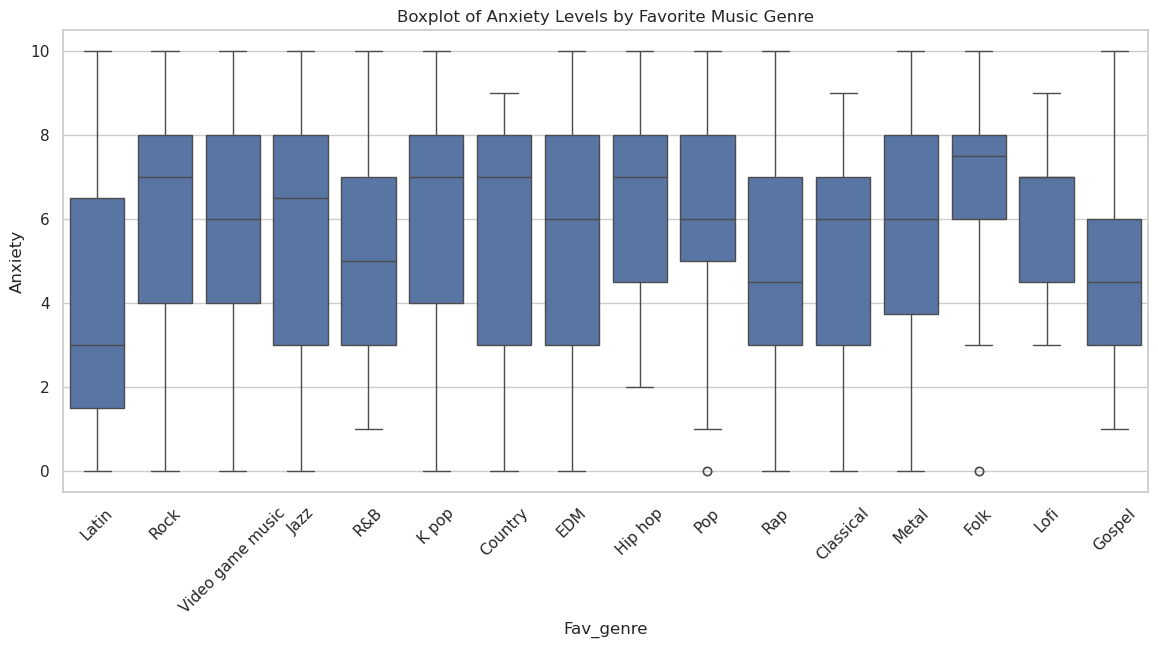

In [124]:
# Setting up the visualization style
sns.set(style="whitegrid")

# Visualization 1: Boxplot of Mental Health Metrics by Favorite Genre
plt.figure(figsize=(14, 6))
sns.boxplot(x='Fav_genre', y='Anxiety', data=data)
plt.xticks(rotation=45)
plt.title('Boxplot of Anxiety Levels by Favorite Music Genre')
plt.show()

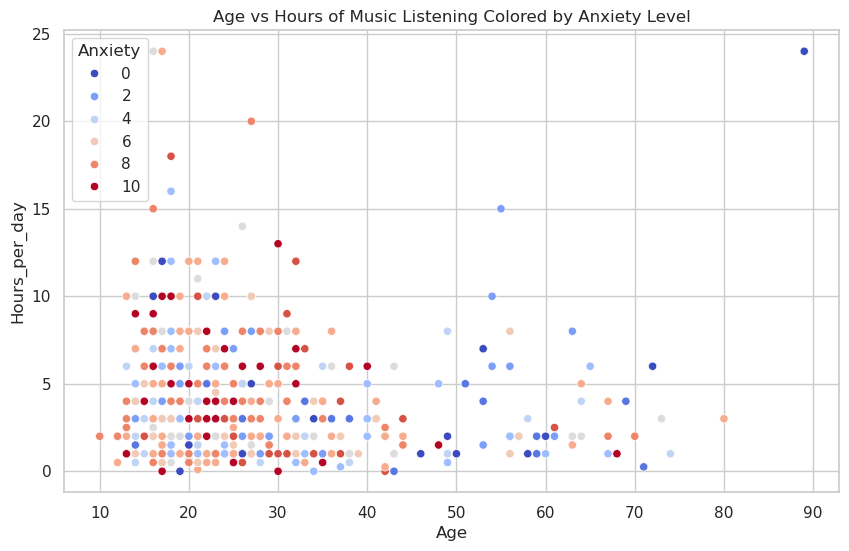

In [125]:
# Visualization 2: Scatter Plot of Age vs Hours of Music Listening Colored by Mental Health Metric
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Hours_per_day', hue='Anxiety', data=data, palette='coolwarm')
plt.title('Age vs Hours of Music Listening Colored by Anxiety Level')
plt.show()

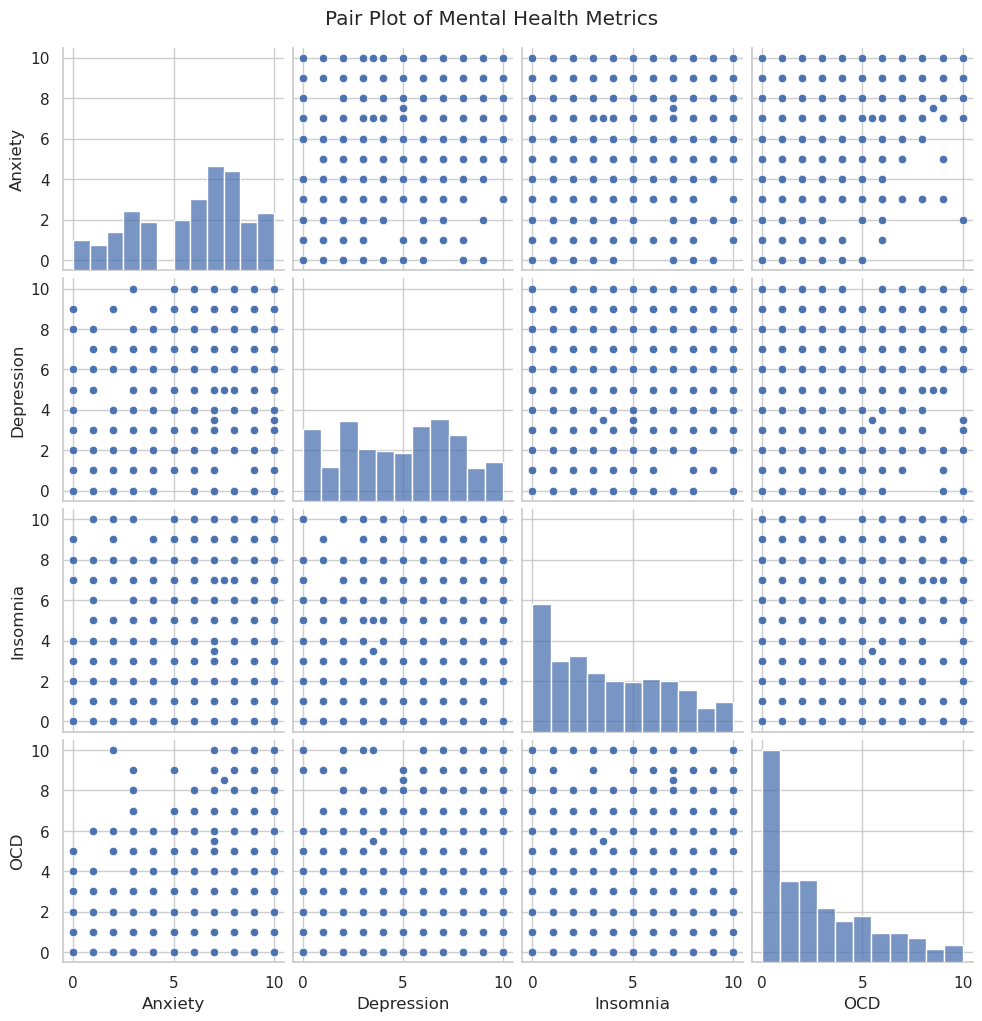

In [126]:
# Visualization 3: Pair Plot for Mental Health Metrics
mental_health_cols = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
sns.pairplot(data[mental_health_cols])
plt.suptitle('Pair Plot of Mental Health Metrics', y=1.02)
plt.show()

In [127]:
# Preparing the data
X = data_encoded.drop(['Anxiety', 'Timestamp'], axis=1)  # Drop 'Timestamp' if it's not a feature
y = data_encoded['Anxiety']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),  # Replace Linear Regression with Logistic Regression
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Training and evaluating models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse

# Displaying the MSE of each model
for name, mse in results.items():
    print(f"{name} - Mean Squared Error: {mse}")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Mean Squared Error: 12.5625
Random Forest - Mean Squared Error: 5.62750945945946
Gradient Boosting - Mean Squared Error: 6.263413109944628


In [128]:
def categorize_anxiety(score):
    if score <= 3:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    else:
        return 'High'

# Apply the function to the 'Anxiety' column
data_encoded['Anxiety_Cat'] = data_encoded['Anxiety'].apply(categorize_anxiety)

In [129]:
# Encoding the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(data_encoded['Anxiety_Cat'])

# Splitting the data (using the same X as before)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train_encoded)

# Predictions
y_pred_rf_class = rf_classifier.predict(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf_class)
precision_rf = precision_score(y_test_encoded, y_pred_rf_class, average='macro')
recall_rf = recall_score(y_test_encoded, y_pred_rf_class, average='macro')
f1_rf = f1_score(y_test_encoded, y_pred_rf_class, average='macro')

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Random Forest Classifier Metrics:
Accuracy: 0.6081081081081081
Precision: 0.49745670995670993
Recall: 0.49197957664078285
F1 Score: 0.47354892205638466


In [130]:
# Train the Logistic Regression model
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train, y_train_encoded)

# Predictions
y_pred_lr_class = lr_classifier.predict(X_test)

# Evaluation
accuracy_lr = accuracy_score(y_test_encoded, y_pred_lr_class)
precision_lr = precision_score(y_test_encoded, y_pred_lr_class, average='macro')
recall_lr = recall_score(y_test_encoded, y_pred_lr_class, average='macro')
f1_lr = f1_score(y_test_encoded, y_pred_lr_class, average='macro')

print("Logistic Regression Classifier Metrics:")
print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")

Logistic Regression Classifier Metrics:
Accuracy: 0.2905405405405405
Precision: 0.3512077294685991
Recall: 0.3670886075949367
F1 Score: 0.19479985278517462


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
# Train the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train_encoded)

# Predictions
y_pred_gb_class = gb_classifier.predict(X_test)

# Evaluation
accuracy_gb = accuracy_score(y_test_encoded, y_pred_gb_class)
precision_gb = precision_score(y_test_encoded, y_pred_gb_class, average='macro')
recall_gb = recall_score(y_test_encoded, y_pred_gb_class, average='macro')
f1_gb = f1_score(y_test_encoded, y_pred_gb_class, average='macro')

print("Gradient Boosting Classifier Metrics:")
print(f"Accuracy: {accuracy_gb}")
print(f"Precision: {precision_gb}")
print(f"Recall: {recall_gb}")
print(f"F1 Score: {f1_gb}")

Gradient Boosting Classifier Metrics:
Accuracy: 0.5675675675675675
Precision: 0.5090078766549355
Recall: 0.5110591071871787
F1 Score: 0.5099886191132056


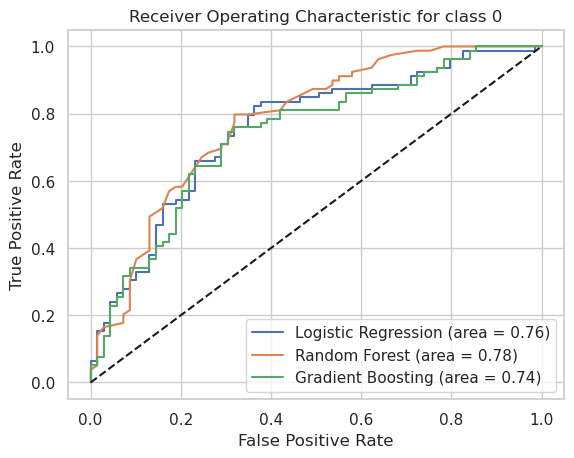

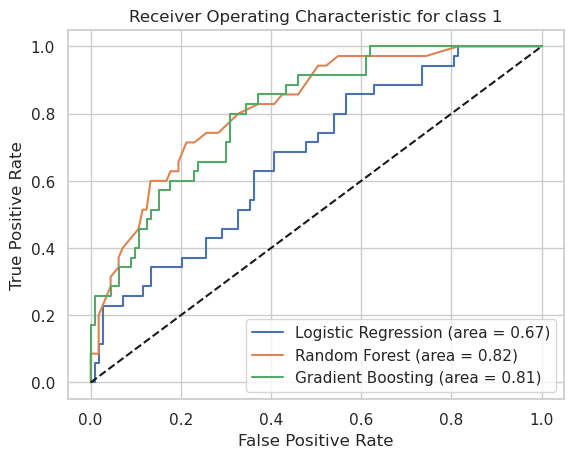

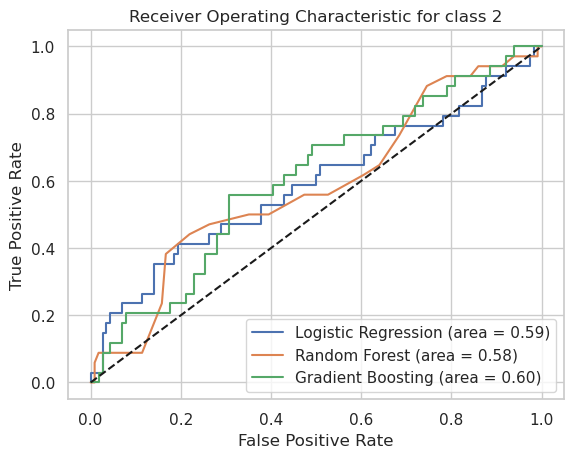

In [132]:
# Binarize the output classes
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2])

# Function to compute ROC curve and ROC area for each class
def compute_multiclass_roc_auc(model, X_test, y_test_binarized, n_classes):
    y_score = model.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

# Compute ROC curve and ROC area for each model
n_classes = 3
fpr_lr, tpr_lr, roc_auc_lr = compute_multiclass_roc_auc(lr_classifier, X_test, y_test_binarized, n_classes)
fpr_rf, tpr_rf, roc_auc_rf = compute_multiclass_roc_auc(rf_classifier, X_test, y_test_binarized, n_classes)
fpr_gb, tpr_gb, roc_auc_gb = compute_multiclass_roc_auc(gb_classifier, X_test, y_test_binarized, n_classes)

# Plotting ROC curves
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr_lr[i], tpr_lr[i], label=f'Logistic Regression (area = {roc_auc_lr[i]:.2f})')
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Random Forest (area = {roc_auc_rf[i]:.2f})')
    plt.plot(fpr_gb[i], tpr_gb[i], label=f'Gradient Boosting (area = {roc_auc_gb[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {i}')
    plt.legend(loc="lower right")
    plt.show()